## Qiskit Examples
#### ECE/CSC 469, Spring 2025
This notebook is intended as a reference for basic Qiskit usage, including creating circuits, running simulations, and presenting data and outcomes. The [Qiskit documentation](https://docs.quantum.ibm.com/api/qiskit/1.2) should be consulted for more detailed information. We are using **Qiskit 1.2** to be consistent with the pre-built qbraid environment.

To run in qbraid, use the `Python 3 [Qiskit 1.2.0]` kernel, which should have the libraries you need already installed.

### Building Circuits

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

The primary way to express a quantum computation is through the creation of a `QuantumCircuit` that consists of qubits and gates/instructions. The qubits may be grouped into `QuantumRegister`s, which allows you to address them by name, but they can also be addressed by their index, or position in the circuit.  

The top-most qubit in a circuit diagram is index 0, and it represents the least significant qubit when describing the state in terms of the computational basis state.

For example, here is a circuit with five qubits. By default, a qubit is labeled as `q` followed by a number that is arbitrarily generated by Qiskit. (They don't necessarily correspond to the index, which is determined by the qubit's position.)

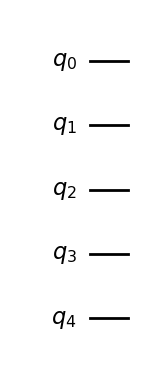

In [4]:
qc = QuantumCircuit(5)  # a circuit with five qubits
qc.draw('mpl')

A `QuantumRegister` is a group of qubits that share a name and are reference by index within the register.  When you create a `QuantumCircuit` you can indicate the registers that are part of the circuit.  Typically, we give a name to a register, but it's not required.

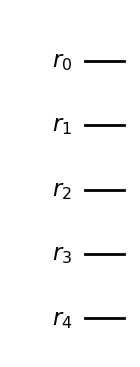

In [5]:
qr = QuantumRegister(5, name="r")
qc = QuantumCircuit(qr)
qc.draw('mpl')

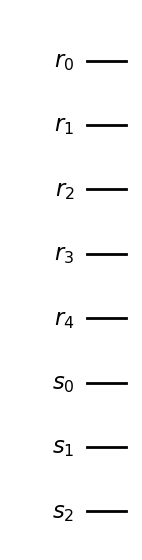

In [6]:
s = QuantumRegister(3, 's')
qc = QuantumCircuit(qr, s)
qc.draw('mpl')

Note that the order of registers is top to bottom, and each register has its bits index from top (least significant) to bottom (most significant).

Now that we have qubits, we can add gates using a variety of `QuantumCircuit` [methods to add gates](https://docs.quantum.ibm.com/api/qiskit/1.2/qiskit.circuit.QuantumCircuit#methods-to-add-standard-instructions) to the circuit.  

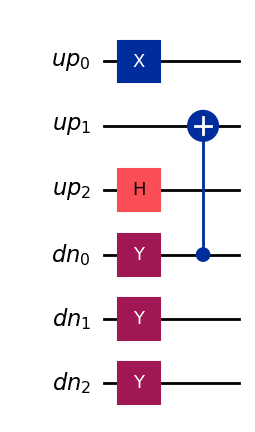

In [7]:
up = QuantumRegister(3, 'up') 
dn = QuantumRegister(3, 'dn') 
qc = QuantumCircuit(up,dn)
qc.x(up[0])  # add an X gate to qubit 0 in register up
qc.h(up[2])  # add an H gate to qubit up[2]
qc.y(dn)  # add a Y gate to all qubits in register dn
qc.cx(dn[0],up[1])  # add a CNOT with dn[0] as the control and up[1] as the target
qc.draw('mpl')

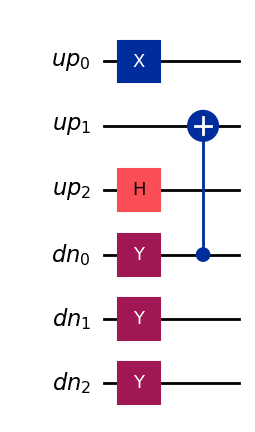

In [8]:
# in this code, we do the same thing but use qubit indices instead of registers
qc = QuantumCircuit(up,dn)
qc.x(0)  # add an X gate to qubit 0 in register up
qc.h(2)  # add an H gate to qubit up[2]
qc.y([3,4,5])  # add a Y gate to all qubits in register dn
qc.cx(3,1)  # add a CNOT with dn[0] as the control and up[1] as the target
qc.draw('mpl')

You can also use a "slice" of a register for an argument that takes a register or list of qubits.

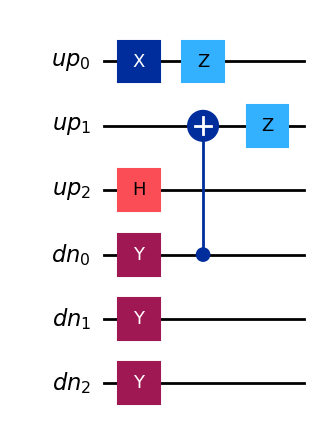

In [9]:
qc.z(up[0:2])  # remember that upper limit is NOT included
qc.draw('mpl')

To add a measurement, we must add a `ClassicalRegister` to the circuit. The classical register will "receive" the result of the measurement, and both the qubit (or quantum register) and the classical bit (or classical register) must be specified when using the `measure` method.

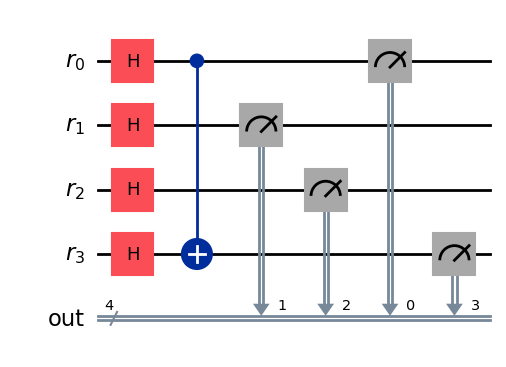

In [10]:
r = QuantumRegister(4, 'r') 
out = ClassicalRegister(4, 'out') 
qc = QuantumCircuit(r, out) 
qc.h(r) 
qc.cx(r[0],r[3]) 
qc.measure(r,out) 
qc.draw('mpl') 

For convenience, the `measure_all` method creates classical bits to receive the measurement results. If you just want to measure everything, you can skip creating the `ClassicalRegister` at the beginning.  In thie case the name of the classical register will be *meas*.

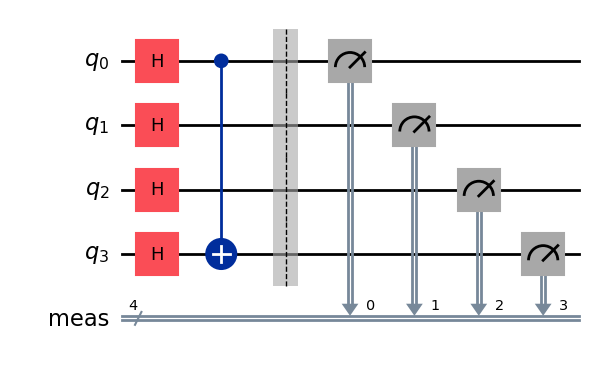

In [11]:
qc = QuantumCircuit(4) 
qc.h(list(range(0,4))) 
qc.cx(0,3) 
qc.measure_all() 
qc.draw('mpl')

That funny vertical bar that you see before the measurements is called a *barrier*. It ensures that all qates to the left have completed execution before any of the gates on the right are executed. This is inserted automatically by the `measure_all` method, but you can add your barriers if you want.

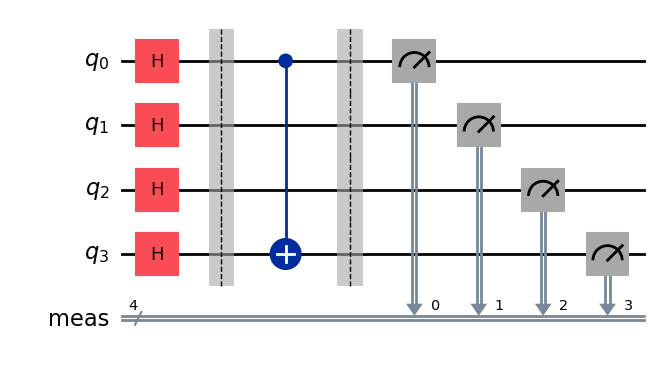

In [12]:
qc = QuantumCircuit(4) 
qc.h(list(range(0,4))) 
qc.barrier() 
qc.cx(0,3) 
qc.measure_all() 
qc.draw('mpl')

Keep in mind that this Python code is only building the circuit. It is not executing the circuit. We can use loops, functions, etc., in the code that builds the circuit.  For example:

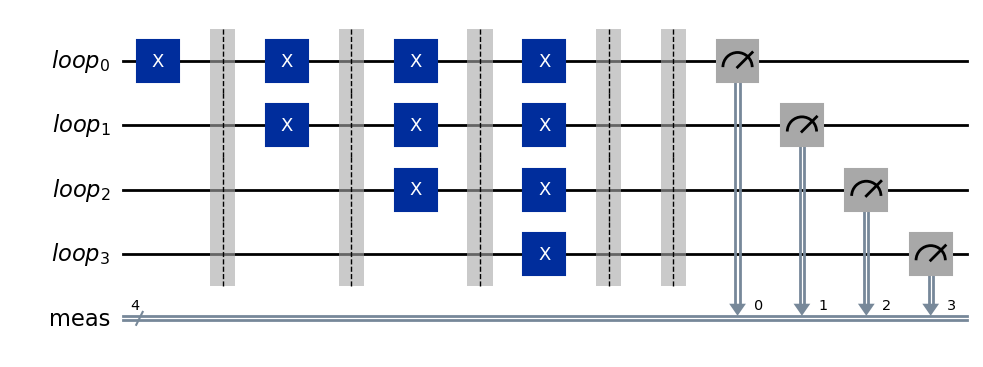

In [13]:
qr = QuantumRegister(4,'loop') 
qc = QuantumCircuit(qr) 
for i in range(0,4):
    qc.x(qr[0:i+1])
    qc.barrier()
qc.measure_all() 
qc.draw('mpl')

One strategy for building complex circuits is to write functions that build subcircuits, and then use the `.append()` method to add the returned circuit to the end of the one we're building.  We can specify the qubits that are connected to the appended circuit.

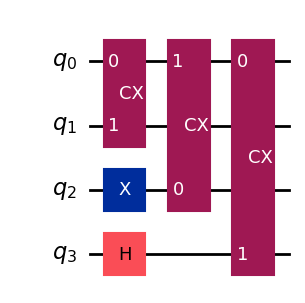

In [14]:
def justCNOT():
    qc = QuantumCircuit(2, name="CX") 
    qc.cx(0,1) 
    return qc

main = QuantumCircuit(4) 
main.x(2) 
main.h(3) 
main.append(justCNOT(), [0,1]) 
# our qubit 2 will be used as qubit 1 inside the appended circuit
main.append(justCNOT(), [2,0]) 
main.append(justCNOT(), [0,3]) 
main.draw('mpl')

Notice that the appended circuit gets drawn as a single blob.  That's nice for abstraction, but we may want to see what's inside.  Use the `.decompose` method to open up the box.  But keep in mind that even the native gates might be decomposed into something that doesn't quite look familiar.

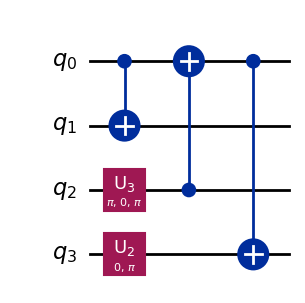

In [15]:
main.decompose().draw('mpl')

### Gates and Matrices
The methods that we've been using to add gates to the circuit rely on a library of `Gate` and `Instruction` objects that are part of the [Qiskit QuantumCircuit library](https://docs.quantum.ibm.com/api/qiskit/1.2/circuit_library).

As you know, an $n$-qubit qate is described by a $2^n \times 2^n$ matrix. You can retrieve the matrix representation of a gate by creating an `Operator` and using its `.data` attribute to get a matrix (type is `numpy.ndarray`).

In [16]:
from qiskit.circuit.library import XGate, YGate, ZGate, HGate, CXGate, RXGate
from qiskit.circuit.library import XXPlusYYGate
from qiskit.quantum_info import Operator
import numpy as np

In [17]:
op = Operator(XGate()) 
print(op.data)

[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]


A nice LaTeX converter draws the matrix in a pleasant math-like format.

In [18]:
from qiskit.visualization import array_to_latex

In [19]:
array_to_latex(op.data)

<IPython.core.display.Latex object>

In [20]:
array_to_latex(op.data, prefix="X=")

<IPython.core.display.Latex object>

In [21]:
op = Operator(HGate()) 
print(op.data) 
array_to_latex(op.data, prefix="H=")

[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]


<IPython.core.display.Latex object>

The floating point precision of Python floating-point numbers is ridiculous. I strongly recomment that you use `np.set_print_precision` to limit the digits, or use `np.round` when you are printing result for humans to read.

In [22]:
np.set_printoptions(precision=3) 
print(op.data)

[[ 0.707+0.j  0.707+0.j]
 [ 0.707+0.j -0.707+0.j]]


Here are some more interesting matrices.

In [23]:
op = Operator(CXGate()) 
array_to_latex(op.data, prefix="\mathit{CX}=")

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_17986/3409461625.py:2: SyntaxWarning: invalid escape sequence '\m'
  array_to_latex(op.data, prefix="\mathit{CX}=")


<IPython.core.display.Latex object>

In [24]:
op = Operator(RXGate(np.pi/2))
array_to_latex(op.data, prefix="R_X(\pi/2)=")

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_17986/629936723.py:2: SyntaxWarning: invalid escape sequence '\p'
  array_to_latex(op.data, prefix="R_X(\pi/2)=")


<IPython.core.display.Latex object>

You can append a gate directly to a circuit, which helps in cases where there might not be a corresponding method.

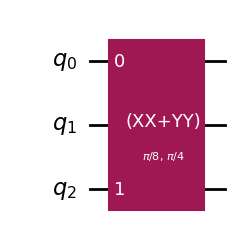

In [25]:
qc = QuantumCircuit(3) 
qc.append(XXPlusYYGate(np.pi/8, np.pi/4), [0,2]) 
qc.draw('mpl')

And you can convert an entire circuit to an `Operator` and look at its matrix.

In [26]:
op = Operator(qc) 
array_to_latex(op.data,precision=3)

<IPython.core.display.Latex object>

Any gate can be transformed into a *controlled* gate by adding one or more control bits. (The default value for `num_ctrl_qubits` is 1.)

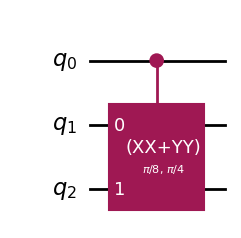

In [27]:
cgate = XXPlusYYGate(np.pi/8, np.pi/4).control(num_ctrl_qubits=1)
qc = QuantumCircuit(3) 
qc.append(cgate, [0,1,2]) # first qubit is the control
qc.draw('mpl')

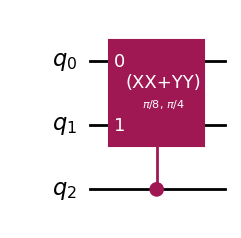

In [28]:
qc = QuantumCircuit(3) 
qc.append(cgate, [2,0,1]) # first qubit is the control
qc.draw('mpl')

### State Vector
One representation of the state of a quantum system is the *state vector*. An $n$-qubit state has a $2^n$-dimensional state vector, and each dimension has an associated complex *amplitude*.

Qiskit provides the [Statevector](https://docs.quantum.ibm.com/api/qiskit/1.2/qiskit.quantum_info.Statevector) class that provides a lot of ways to create and visualize quantum state. You can initialize a state vector using a 1D array or a list of values.

In [29]:
from qiskit.quantum_info import Statevector

In [30]:
sv = Statevector([0.5,0.5,-0.5,-0.5])  # equal superposition 
print(sv.data)

[ 0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]


As above, you can retrieve the vector data, but if you just want to print the vector, you can use the `.draw()` method.

In [31]:
sv.draw('text')

[ 0.5+0.j, 0.5+0.j,-0.5+0.j,-0.5+0.j]

The `.draw()` method provides a variety of output formats, including the Bloch sphere representation of each qubit. (This is not as useful as it seems for multi-qubit states...)

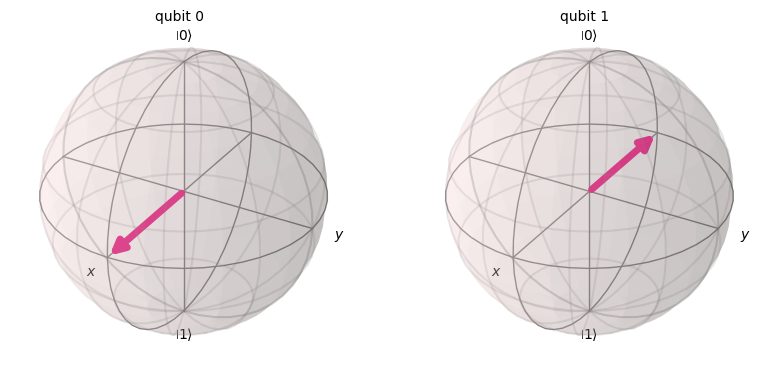

In [32]:
sv.draw('bloch')

Note that this has the annoying property of drawing the qubits in the "wrong" order, with the least significant on the left. To fix it, pass the `reverse_qubits=True` parameter to the function.

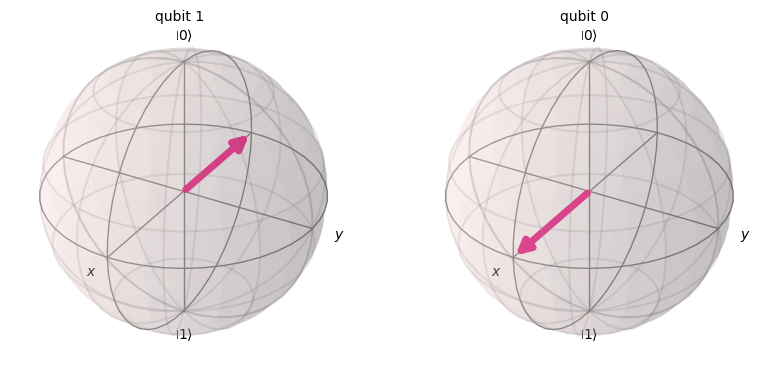

In [33]:
sv.draw('bloch', reverse_bits=True)

In [34]:
sv.draw('latex')

<IPython.core.display.Latex object>

You can initialize a `Statevector` using a `QuantumCircuit`, which shows the result of applying the circuit to an initial input of all zeros.

In [35]:
qc = QuantumCircuit(2) 
qc.h(0)  # Bell state circuit
qc.cx(0,1) 
sv = Statevector(qc) 
sv.draw('latex')

<IPython.core.display.Latex object>

What happens if the initialization vector is not normalized?

In [36]:
sv = Statevector([1,2,3,4]) 
sv.draw('latex')

<IPython.core.display.Latex object>

Qiskit lets you do it, but the resulting `Statevector` is invalid and won't be useful for anything...

In [37]:
print(sv.is_valid())

False


One way to prepare a `Statevector` in a computational basis state is to use the `.from_int()` function. The bits in the integer argument will be used to prepare the corresponding basis state.  You also have to specify the dimensionality of the desired state.

In [38]:
sv = Statevector.from_int(5,(2,2,2,2)) # four 2D subsystems
sv.draw('latex')

<IPython.core.display.Latex object>

Or you can initialize using a string, with each character in the string corresponding to one of the "special" states that we identify on the Bloch sphere:

| Label | State |
|-------|-------|
|'0'|$|0\rangle$|
|'1'|$|1\rangle$|
|'+'|$|+\rangle$|
|'-'|$|-\rangle$|
|'r'|$|i\rangle$|
|'l'|$|-i\rangle$|




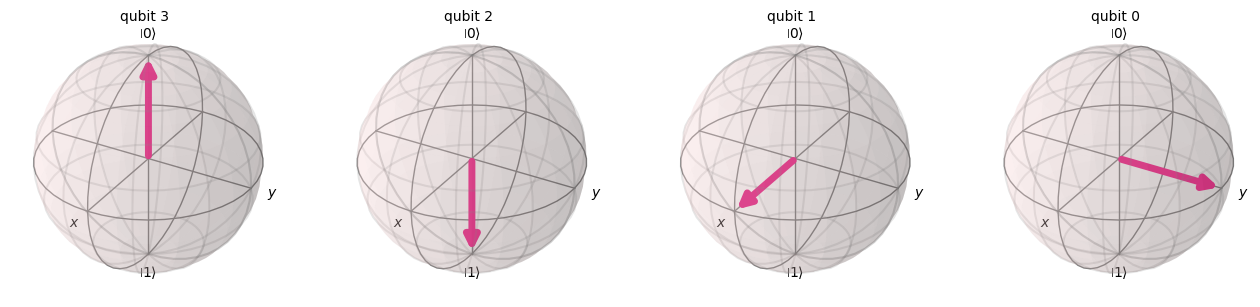

In [39]:
sv = Statevector.from_label("01+r") 
sv.draw('bloch', reverse_bits=True)
# Draws bloch sphere

In [40]:
sv.draw('latex')

<IPython.core.display.Latex object>

In [41]:
print(sv.draw())

Statevector([0. +0.j , 0. +0.j , 0. +0.j , 0. +0.j , 0.5+0.j , 0. +0.5j,
             0.5+0.j , 0. +0.5j, 0. +0.j , 0. +0.j , 0. +0.j , 0. +0.j ,
             0. +0.j , 0. +0.j , 0. +0.j , 0. +0.j ],
            dims=(2, 2, 2, 2))


In [42]:
array_to_latex(sv.data, max_size=16)

<IPython.core.display.Latex object>

`Statevector` also provides the `.evolve()` method, which applies an operator or circuit to an existing state to produce a new state.  This can be a way to "simulate" a circuit and look at the state vector output rather than sampling measurements.

In [43]:
# what happens when we apply the Bell state circuit to an initial state of "10"?
sv = Statevector.from_label("10") 
out = sv.evolve(qc)  # apply the circuit to the state
out.draw('latex')

<IPython.core.display.Latex object>

In [44]:
# look at probabilities instead of amplitudes
print(out.probabilities())

[0.  0.5 0.5 0. ]


In [45]:
print(out.probabilities_dict(decimals=2))

{np.str_('01'): np.float64(0.5), np.str_('10'): np.float64(0.5)}


If you include the `sv_disc.py` file in your directory and import it, you will be able to use this `sv_disc()` function to draw a state vector in a style similar to the textbook.

In [46]:
%pip install colorcet #Replaced ! with %
from sv_disc import *

Note: you may need to restart the kernel to use updated packages.


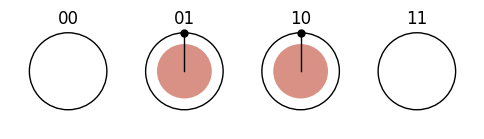

In [47]:
sv_disc(out)

### Aer Simulator
One way to simulate the execution of a circuit on a quantum computer is to use [Qiskit Aer](https://qiskit.github.io/qiskit-aer/), an open-source simulator that was spun out of Qiskit, replaced by the Sampler and Estimator primitives.

To use `AerSimulator`, you create a circuit, transpile it to the simulator gate set, include some measurements, and run it.  The result is a dictionary of output measurements, with the number of time each of those outputs was observed. The `plot_histogram` function is a convenient way to visualize those results.

In [48]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

First, let's create a circuit. This is just a random circuit that doesn't do anything in particular.

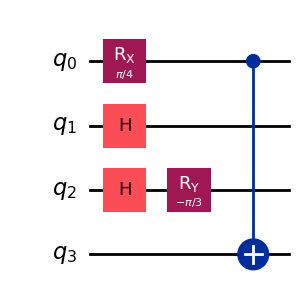

In [49]:
qc = QuantumCircuit(4) 
qc.h(1) 
qc.rx(np.pi/4, 0) 
qc.h(2) 
qc.ry(-np.pi/3, 2) 
qc.cx(0,3) 
qc.draw('mpl')

What is the state vector that results from applying this circuit to an initial state of zero? (Note that we can't use any measurements when we work with state vectors directly.)

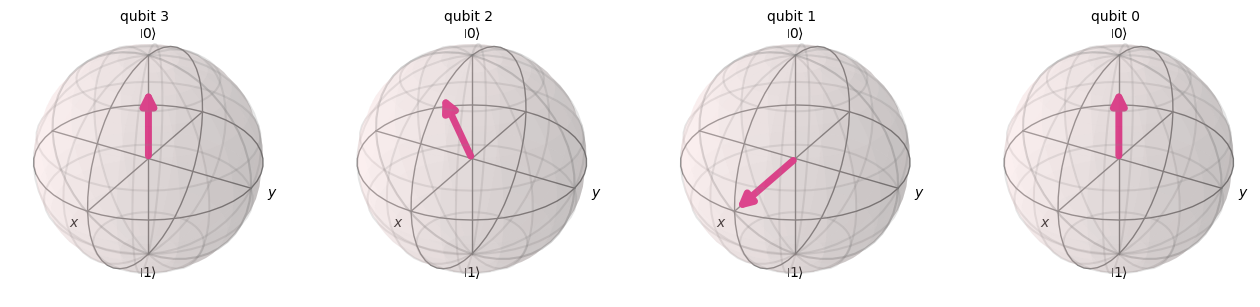

In [50]:
sv = Statevector(qc) 
sv.draw('bloch', reverse_bits=True)

In [51]:
sv.draw('latex', decimals=2) 

<IPython.core.display.Latex object>

In [52]:
print(sv.probabilities_dict(decimals=3))

{np.str_('0000'): np.float64(0.398), np.str_('0010'): np.float64(0.398), np.str_('0100'): np.float64(0.029), np.str_('0110'): np.float64(0.029), np.str_('1001'): np.float64(0.068), np.str_('1011'): np.float64(0.068), np.str_('1101'): np.float64(0.005), np.str_('1111'): np.float64(0.005)}


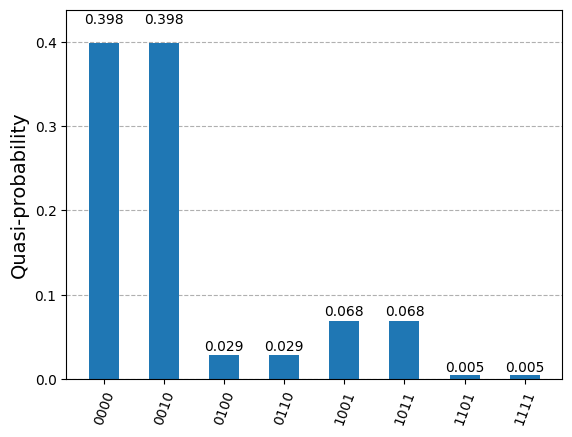

In [53]:
plot_histogram(sv.probabilities_dict())

Now let's simulate the circuit, and see if the output samples match up well with the state vector.  

In [54]:
qc.measure_all()   # add measurements for simulator

In [55]:
# Transpile for simulator
simulator = AerSimulator()
tc = transpile(qc, simulator)

# Run and get counts
result = simulator.run(tc).result()
counts = result.get_counts(tc)
print(counts)

{'1111': 6, '1001': 64, '1011': 74, '1101': 8, '0110': 27, '0100': 29, '0000': 389, '0010': 427}


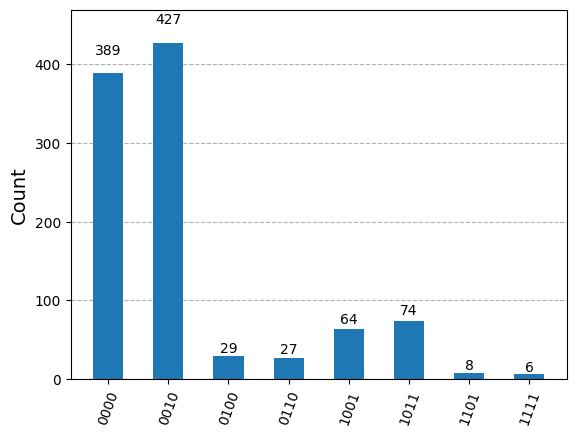

In [56]:
plot_histogram(counts)

Why don't the graphs look the same?  When we generate a state and measure it, the result is probabilistic. So we get some *sampling error* when we look at the outcome.  Let's increase the number of *shots* to generate more samples.

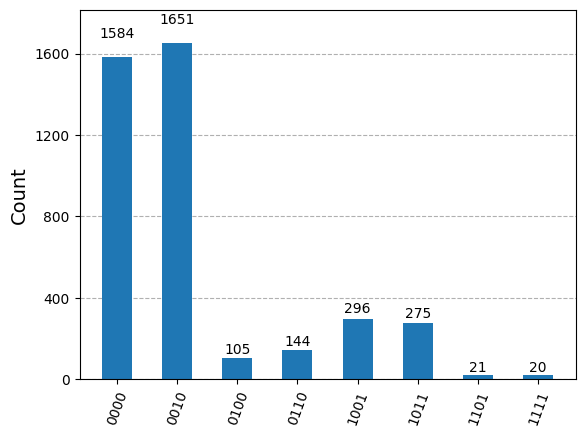

In [57]:
result = simulator.run(tc,shots=4096).result()
counts = result.get_counts(tc)
plot_histogram(counts)

Note that we *transpiled* the circuit to match the gates allowed in the simulator.  What does that transpiled circuit look like?

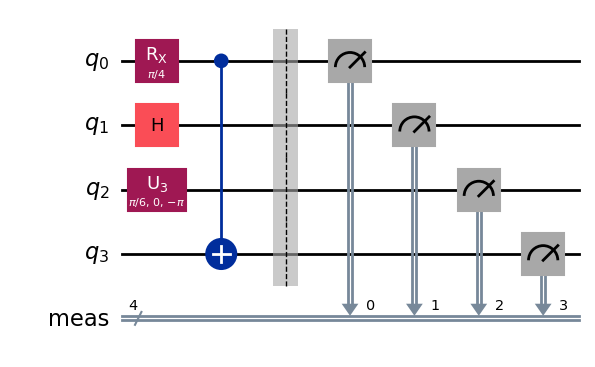

In [58]:
tc.draw('mpl')

The only noticeable change is that the $H$ and $R_Y$ gates have been combined into a single "universal" gate. For more complicated circuits, we are likely to the effects of a number of optimizations.